# Line ratios in the mid-infrared

The idea is to look at the ionization-sensitive ratios and compare them with the optical

In [33]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from matplotlib import pyplot as plt
from reproject import reproject_interp
from dataclasses import dataclass
from typing import Union

import seaborn as sns
import numpy as np

from pathlib import Path


In [2]:
datapath = Path.cwd().parent.parent / "data-jesus"

## Get all maps on a common grid

Read in the IRS line maps theat Jesús made for us

In [3]:
linedict = {
    #    "Ar III": "SL1_map_9.0_ArIII",
    "S IV": "SL1_map_10.5_SIV",
    "S III": "LL2_map_18.7_SIII",
    "Ne II": "SL1_map_12.8_NeII",
    "Ne III": "LL2_map_15.5_NeIII",
    "cont14": "SL1_map_cont_13-14",
    "cont09": "SL1_map_cont_8.5-10",
    "S IIIb": "LL1_map_33.4_SIII",
    "Si II": "LL1_map_34.8_SiII",
    "cont27": "LL1_map_cont_25-30",
    "PAH": "SL1_map_11.3_PAH",
}

I have dropped [Ar III] because it is too noisy

In [4]:
hdus = {
    label: fits.open(datapath / f"ngc346_{string}.fits")[0]
    for label, string in linedict.items()
}

Remove unwanted SIP values from the headers, since otherwise `astropy.wcs` will get upset.

In [5]:
for hdu in hdus.values():
    del hdu.header["PV*"]
    del hdu.header["A_*"]
    del hdu.header["B_*"]

We need to reproject the maps to a common pixel grid before we can to take ratios. We want an orthogonal grid in RA, DEC to make life easier, which we will center on W3

In [6]:
c0 = SkyCoord.from_name("Cl* NGC 346 W 3")

And choose 1 arcsec pixels and 6 arcmin field of view

In [7]:
NY, NX = 6 * 60, 6 * 60
w0 = WCS(naxis=2)
w0.wcs.crpix = [NX / 2, NY / 2]
w0.wcs.crval = [c0.ra.deg, c0.dec.deg]
w0.wcs.cdelt = np.array([-1.0, 1.0]) / 3600.0
w0.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [8]:
maps = {
    label: reproject_interp(
        hdu,
        w0,
        (NY, NX),
        order="nearest-neighbor",
        return_footprint=False,
    )
    for label, hdu in hdus.items()
}

***TODO*** Smoothe all the shorter wave maps to the worst resolution (currently S III)

## Plot the images


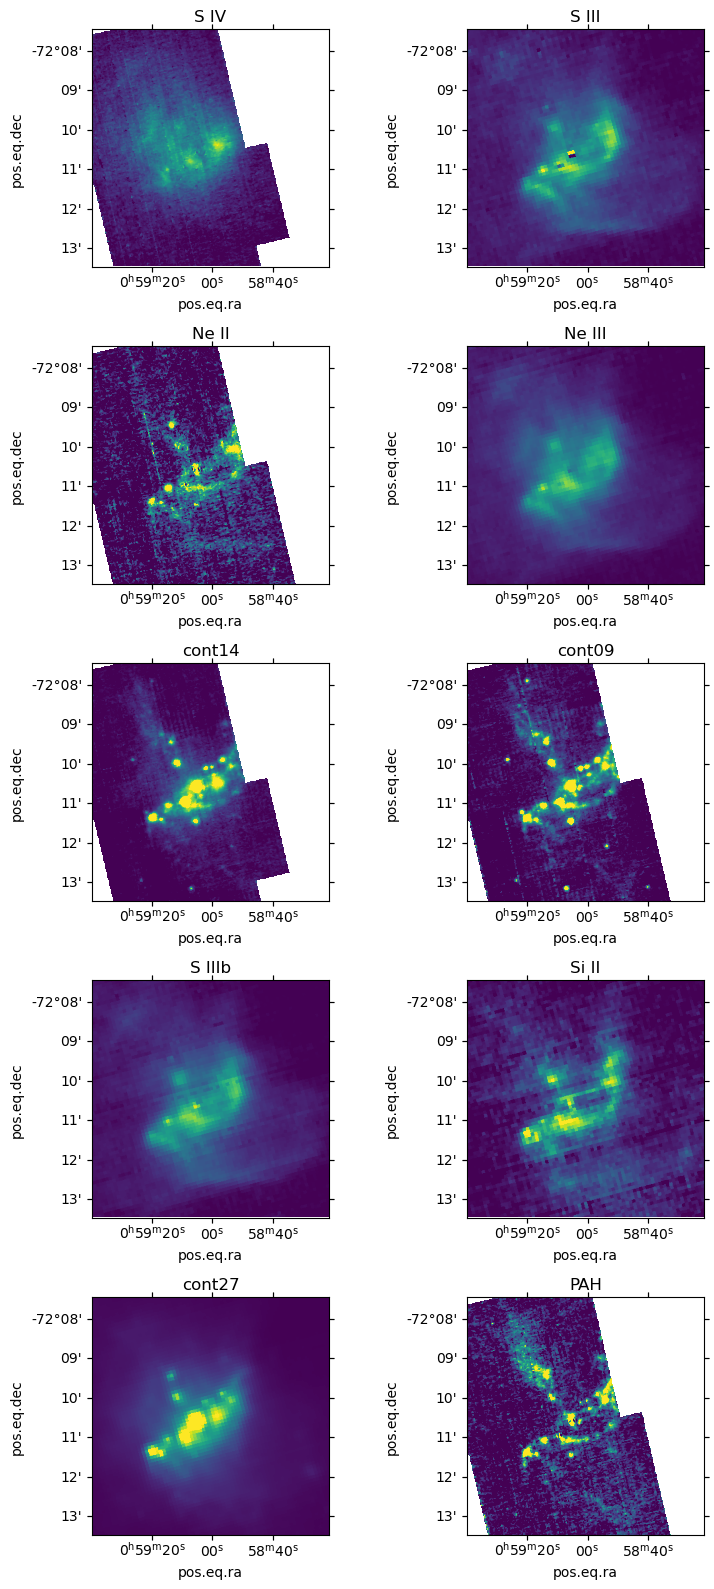

In [9]:
fig, axes = plt.subplots(
    5,
    2,
    figsize=(8, 16),
    subplot_kw=dict(projection=w0),
)
bscale = {}
for ax, line in zip(axes.flat, linedict.keys()):
    mask = np.isfinite(maps[line])
    bscale[line] = 2 * np.percentile(maps[line][mask], 95)
    ax.imshow(maps[line], vmin=0, vmax=bscale[line])
    ax.set_title(line)
fig.tight_layout()

## Make ratios of the images

Define a `Ratio` class, which allows for the sum of one or more bands in both the numerator and denominator.  We only use this for [S III], which has two lines.

We use the same class for calculating equivalent widths as `LINE / CONTINUUM`. This requires "`EW`" to be in the `label` and an extra parameter `dwave` that is the sum of the widths of the continumm bands.

We calculate two different typical valuses for the ratio, the `median` (self-explanatory) and the `scale`, which is the ratio of the 95th centiles of the numerator and denominator. The `scale` turns out to be a better typical value.

In [36]:
@dataclass
class Ratio:
    label: str
    num: Union[str, list[str]]
    den: Union[str, list[str]]
    dwave: float = 1.0
    blur: float = 0.0

    def __post_init__(self):
        if isinstance(self.num, str):
            self.num = [self.num]
        if isinstance(self.den, str):
            self.den = [self.den]
        numerator = np.sum(np.stack([maps[lab] for lab in self.num]), axis=0)
        denominator = np.sum(np.stack([maps[lab] for lab in self.den]), axis=0)
        if self.blur > 0.0:
            kernel = Gaussian2DKernel(x_stddev=self.blur)
            numerator = convolve_fft(numerator, kernel)
            denominator = convolve_fft(denominator, kernel)
        self.ratio = numerator / denominator
        if "EW" in self.label:
            self.ratio *= self.dwave
        self.mask = np.isfinite(self.ratio)
        self.ratio[~self.mask] = np.nan
        self.scale = np.percentile(numerator[self.mask], 95) / np.percentile(
            denominator[self.mask], 95
        )
        self.median = np.nanmedian(self.ratio[self.mask])
        if "EW" in self.label:
            # The median is a better typical value for EWs
            self.scale = self.median

Take all the ratios that might occur to us.

In [11]:
ratios = [
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    Ratio("s33", "S III", "S IIIb"),
    Ratio("ne32", "Ne III", "Ne II"),
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"]),
    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color27-14", "cont27", "cont14"),
    Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5),
    Ratio("EWs3", "S III", "cont27", dwave=5.0),
    Ratio("EWs3b", "S IIIb", "cont27", dwave=5.0),
    Ratio("c14-s4", "cont14", "S IV"),
    Ratio("s4ne2", "S IV", "Ne II"),
    Ratio("c14-s3", "cont14", ["S III", "S IIIb"]),
]

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/1266004768.py:15: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator


### Plot the ratios

We use a logarithmic scale of two dex, centered on the `scale` value

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/37824920.py:11: RuntimeWarning: invalid value encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/37824920.py:11: RuntimeWarning: divide by zero encountered in log10
  np.log10(rat.ratio),


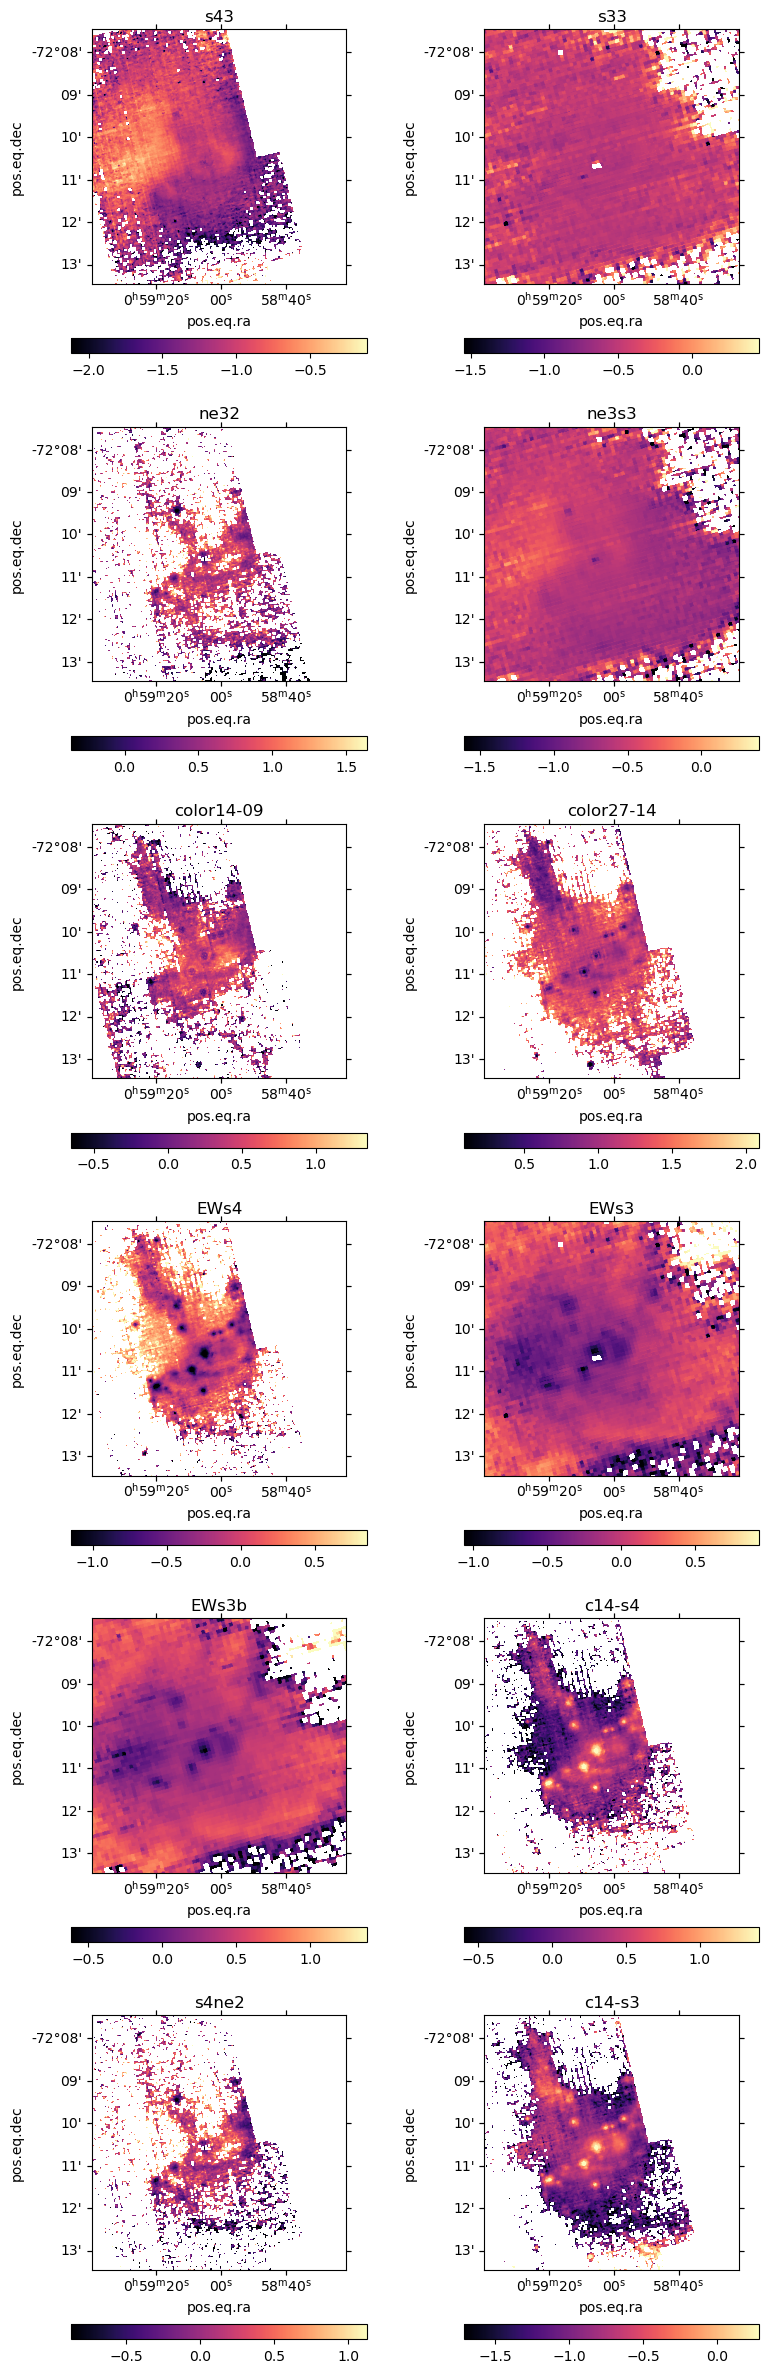

In [12]:
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, ratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()

## Color-color diagrams

### Define a function to make the color-color plots

Creates a 2d histogram from a pair of ratio images

In [13]:
def color_color_plot(rat1, rat2, weights, ax=None, nbins=100):
    mask = rat1.mask & rat2.mask
    x = np.log10(rat1.ratio[mask])
    xmin = np.log10(rat1.scale) - 1.0
    xmax = np.log10(rat1.scale) + 1.0
    y = np.log10(rat2.ratio[mask])
    ymin = np.log10(rat2.scale) - 1.0
    ymax = np.log10(rat2.scale) + 1.0

    H, xedges, yedges = np.histogram2d(
        x,
        y,
        bins=nbins,
        range=[[xmin, xmax], [ymin, ymax]],
        density=True,
        weights=weights[mask],
    )
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(
        H.T,
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect="equal",
        cmap="inferno_r",
        interpolation="none",
    )
    ax.set(
        xlabel=f"log10( {rat1.label} )",
        ylabel=f"log10( {rat2.label} )",
    )
    return im

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/1266004768.py:15: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


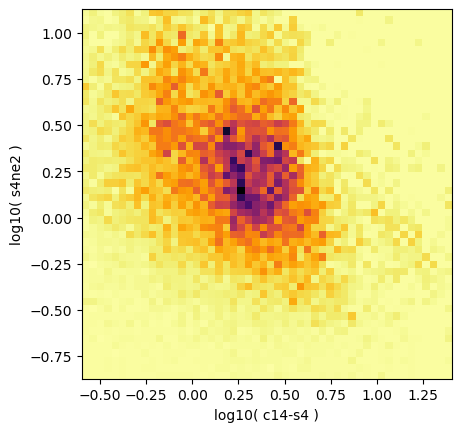

In [14]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("c14-s4", "cont14", "S IV"),
    Ratio("s4ne2", "S IV", "Ne II"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/1266004768.py:15: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


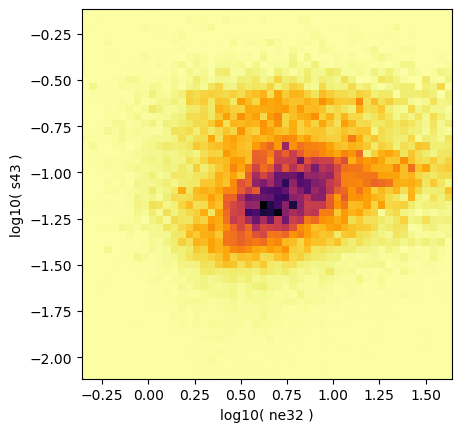

In [15]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne32", "Ne III", "Ne II"),
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


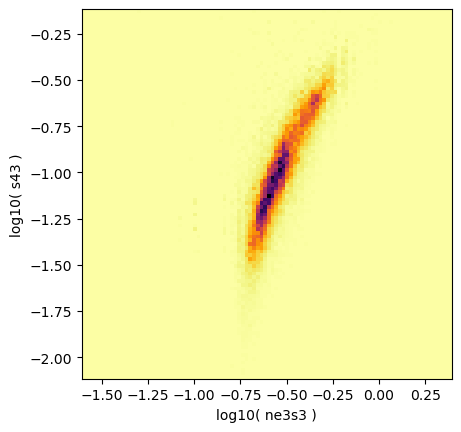

In [16]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"]),
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


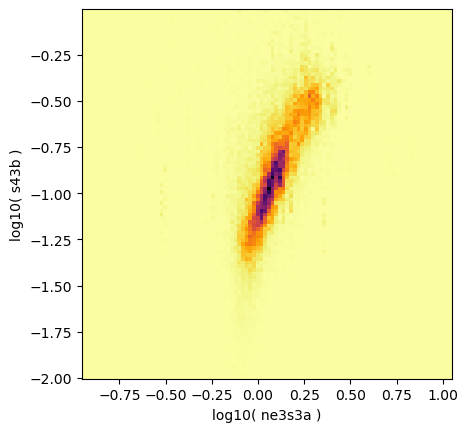

In [17]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3a", "Ne III", "S III"),
    Ratio("s43b", "S IV", "S IIIb"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


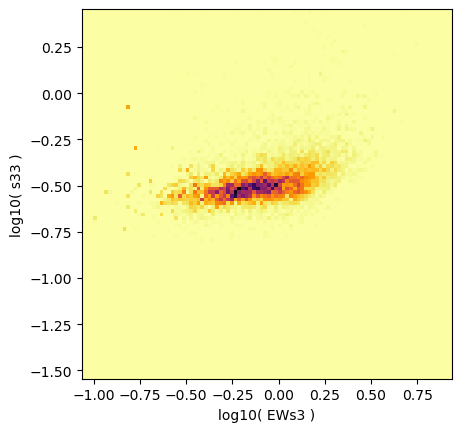

In [18]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("EWs3", "S III", "cont27", dwave=5.0),
    Ratio("s33", "S III", "S IIIb"),
    maps["S III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/1266004768.py:15: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


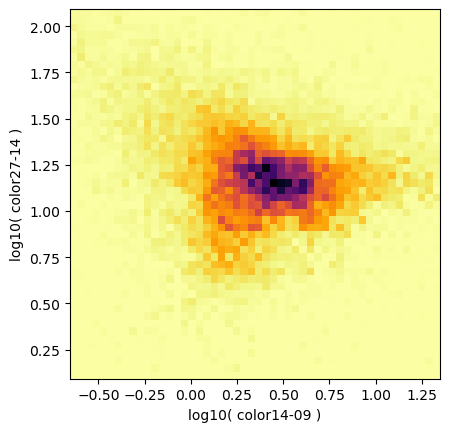

In [19]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


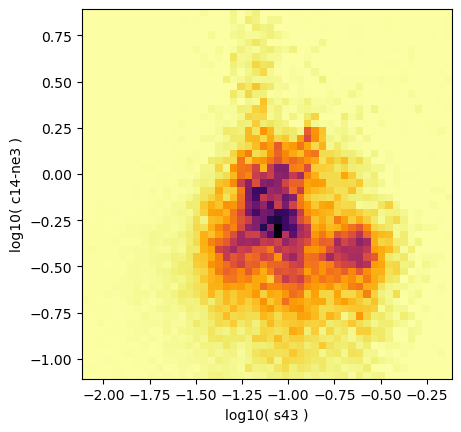

In [20]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    Ratio("c14-ne3", "cont14", "Ne III"),
#   Ratio("c14-s4", "cont14", "S IV"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


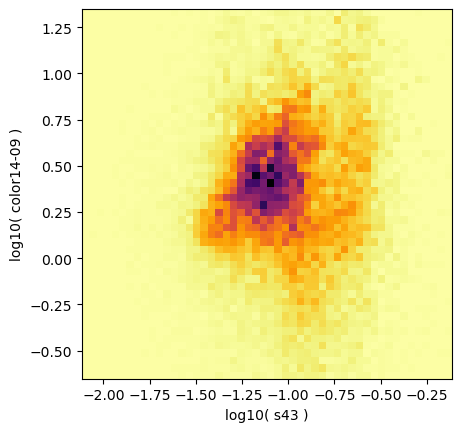

In [21]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    Ratio("color14-09", "cont14", "cont09"),
#    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


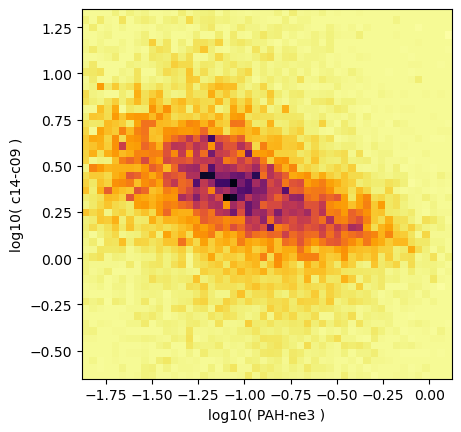

In [22]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("PAH-ne3", "PAH", "Ne III"),
    Ratio("c14-c09", "cont14", "cont09"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

### Use just the 18 micron S III line

This is to make for easier comparison with the Cloudy results



/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


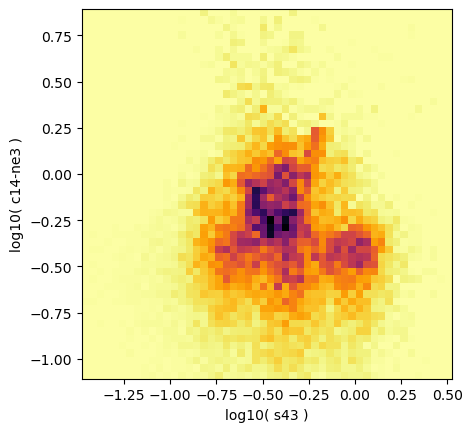

In [38]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=0.0),
    Ratio("c14-ne3", "cont14", "Ne III", blur=0.0),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


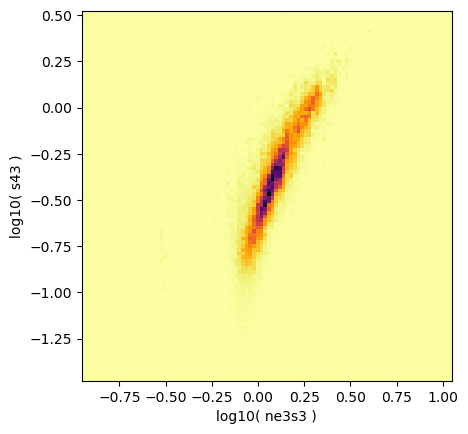

In [24]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", "S III"),
    Ratio("s43", "S IV", "S III"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/1266004768.py:15: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/329387133.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


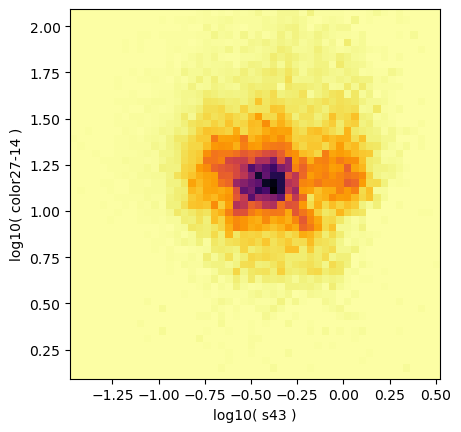

In [31]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III"),
#    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=50,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/3289676385.py:20: RuntimeWarning: divide by zero encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/3289676385.py:20: RuntimeWarning: invalid value encountered in true_divide
  self.ratio = numerator / denominator
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/2005221082.py:18: RuntimeWarning: divide by zero encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/2005221082.py:18: RuntimeWarning: invalid value encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/2005221082.py:24: RuntimeWarning: divide by zero encountered in log10
  ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_82596/2005221082.py:24: RuntimeWarnin

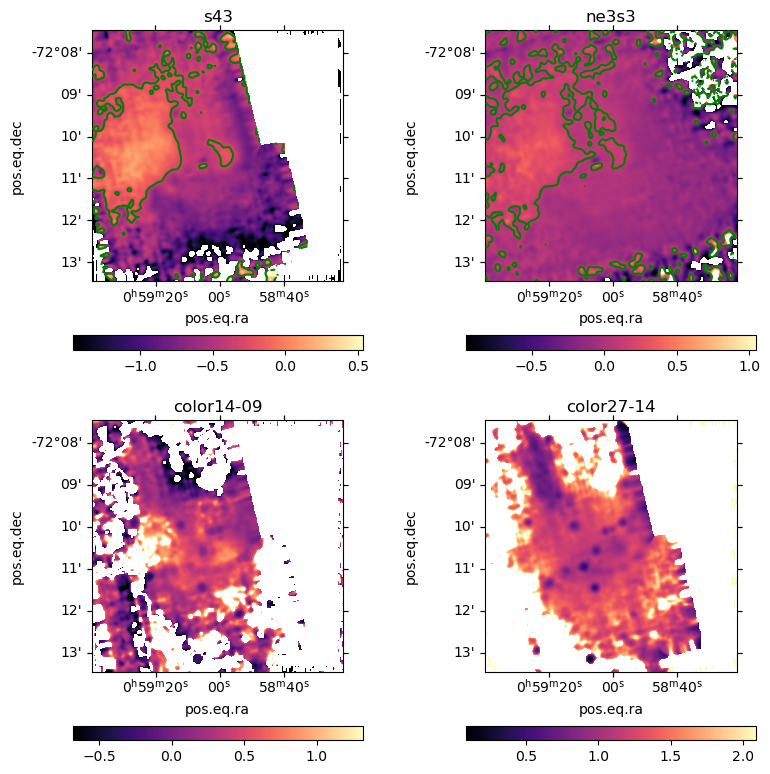

In [47]:
ratios = [
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("ne3s3", "Ne III", "S III", blur=2.5),
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-14", "cont27", "cont14", blur=2.5),
]
leveldict = {"s43": [-0.3], "ne3s3": [0.1]}
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, ratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    if rat.label in leveldict:
        ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()